# MULTI LABEL CLASSIFICATION WITH NLTK

In this tutorial, I will show you how to predict tags for a text. In this post, we will build a multi-label model that’s capable of detecting different types of toxicity in a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are: 
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

The data set used can be downloaded at [Kaggle](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline/data) .  there is a disclaimer on the data set that the dataset contains texts that may be considered profane, vulgar, or offensive. this is applicable to this tutorial as well.

 I would like to acknowledge the National Research University Higher School of Economics of Moscow for most of my codes borrowed from their [github](https://github.com/hse-aml/natural-language-processing/blob/master/Docker-tutorial.md). I would also like to acknowledge Susan Li for her article from which I borrowed the codes used to do the analysis of the tags. [Susan Li's Article](https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5).

To solve this task you will use multilabel classification approach.

### Libraries

In this task I will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

Let's first download the list of stopwords

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The data set contains text data and corresponding tags. for easy operation on the data, let's first load pandas and numpy that we will to structure our data and do operations on the data. let's also deploy matplotlib that we will use for visualisation

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Let's create a function and call it read_data that we can use to load data.
I've already split the data into training data set and test data set that I then saved as Pickle file. you can see the whole process [Here](somelink)

In [3]:
def read_data(filename):
    data = pd.read_pickle(filename)
    return data

In [4]:
train = read_data('data/train.pkl') 
test = read_data('data/test.pkl')

Now that our data is deployed, let's see some statics about our data.

In [5]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,143613.000000,143613.000000,143613.000000,143613.000000,143613.000000,143613.000000
mean,0.096189,0.010076,0.053011,0.003071,0.049341,0.008760
std,0.294851,0.099871,0.224055,0.055329,0.216580,0.093183
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's now print a snapshot of our data to see the structure

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
34117,5b02208daa29a40f,Outrageous!!!!! \n\nThis block is outrageous a...,0,0,0,0,0,0
6579,1190ddc487465bd2,Except that you would never dare say something...,0,0,0,0,0,0
59858,a0473abe447e04e3,Thanks for your reply and your explanation; yo...,0,0,0,0,0,0
86152,e6763dac9d770096,or attempted generalization,0,0,0,0,0,0
7620,1446437fe8605add,You seem to be vandalising the article. Why a...,1,0,0,0,0,0


Now that we have a slight idea of what our data contains. let's first split the training set into train and validation set. the validation set will help us to verify whether our model is learning before we can fit the model to the test set. this is crucial since we should not use the test set to adjust the learning parameters of our models. doing so will leak some features of the test set and our model will fit well the test set and might fail to generalise to unknow data. I've chosen to use a sample of 10% of the training set as the validation data set.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train, validation = train_test_split(train, random_state=42, test_size=0.1, shuffle=True)

Now that we have split the train and validation sets, let's explore our data and find out whether the split operation haven't altered the distribution of our data. we will first examine whether the mean and standard deviation of our training data has remained in the same range.

In [9]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,129251.000000,129251.000000,129251.000000,129251.000000,129251.000000,129251.000000
mean,0.096146,0.010182,0.053083,0.003095,0.049454,0.008774
std,0.294793,0.100390,0.224199,0.055545,0.216815,0.093256
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see that the mean and std for all our class columns have remained in the same range. this a first good sign. However we need to explore deeper and try to understand whether the validation set represents the sample population of our training. to do that we will explore the mean and std and then we will check how each individual class is distributed in both the training set and the validation set

In [10]:
validation.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,14362.000000,14362.000000,14362.00000,14362.000000,14362.000000,14362.000000
mean,0.096574,0.009121,0.05236,0.002855,0.048322,0.008634
std,0.295387,0.095072,0.22276,0.053355,0.214453,0.092520
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


We can see that our validation set is indeed doing a good job in representing our sample population. Good, but let's see if it is really good as it shows. let's now list how many comments are tagged by each class(tag). I will call this tags a category. the rule is that the ratio between the classes will remain almost the same on both data sets.

In [11]:
def count_labels_per_category(df):
    
    df_toxic = df.drop(['id', 'comment_text'], axis=1)
    counts = []
    categories = list(df_toxic.columns.values)
    for i in categories:
        counts.append((i, df_toxic[i].sum()))
    df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
    return df_stats

Let's display the count of comments tagged with each category on the training set.

In [12]:
df_stats_train = count_labels_per_category(train)
df_stats_train

,category,number_of_comments
0,toxic,12427
1,severe_toxic,1316
2,obscene,6861
3,threat,400
4,insult,6392
5,identity_hate,1134


let's do the same with the validation set

In [13]:
df_stats_valid = count_labels_per_category(validation)
df_stats_valid

,category,number_of_comments
0,toxic,1387
1,severe_toxic,131
2,obscene,752
3,threat,41
4,insult,694
5,identity_hate,124


You can see that the ration of comments attributed for each tag have remained the same.

Let's now plot this data since it is easier to see via graphs how comments are assigned to tags than to just read numbers.

In [14]:
def plot_count_labels_per_category(df_stats):
    df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
    plt.title("Number of comments per category")
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel('category', fontsize=12)

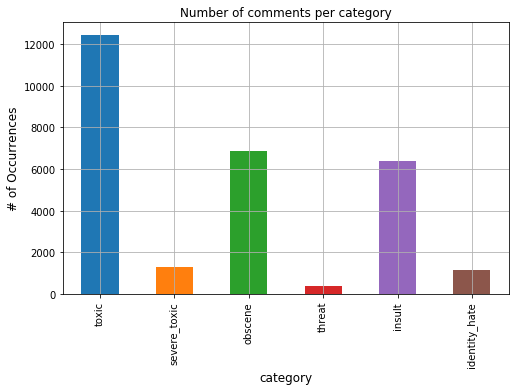

In [15]:
plot_count_labels_per_category(df_stats_train)

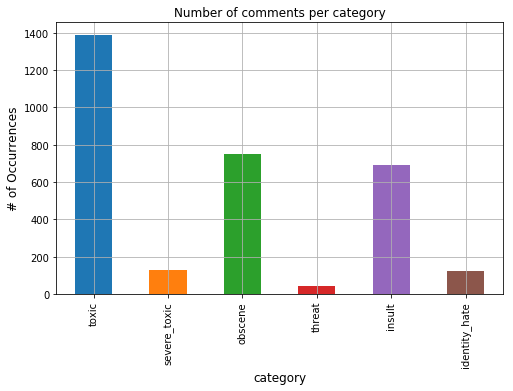

In [16]:
plot_count_labels_per_category(df_stats_valid)

Although we now know how many comments are assigned to each tag, we still lack the big picture since as we know in any multi label problem, one text can be assigned to multiple tags. so we need to understand how many comments have zero tags (or safe comments), how many comments have only one tag, how many comments assigned just two tags, etc...

In [17]:
import seaborn as sns

Text(0.5,0,'# of categories')

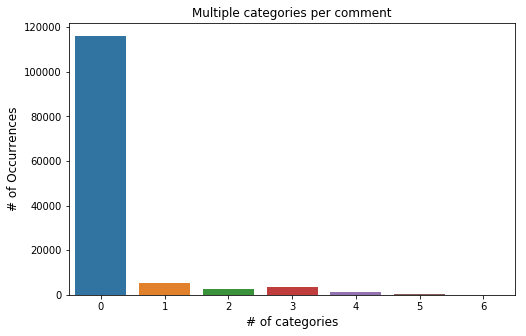

In [18]:
rowsums = train.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

This indeed just revealed something not surprising but important to know. most of our comments are safe and so they don't have a tag. no comment has all tags at a time. looking at the graph we can see that our data set is sparse. so we need to keep this in mind when we evaluate our model. I will talk about this in the section of model evaluation. to understand how sparse our model is, let's calculate the percentage of comments that have no tag on them.

In [19]:
print('Percentage of comments that are not labelled:')
print(len(train[(train['toxic']==0) & (train['severe_toxic']==0) & (train['obscene']==0) & (train['threat']== 0) & (train['insult']==0) & (train['identity_hate']==0)]) / len(train))

Percentage of comments that are not labelled:
0.8980975002127644


We can see that ~ 90% of our data are safe comments. during the evaluation, we need to keep this in mind so that we don't think that our model is doing a good job when in reality it is just assigning all comments to a safe tag. 

So far we have been looking at the distribution of the tags. what about the composition of our comments data? as a matter of curiosity, let see how big are texts in general

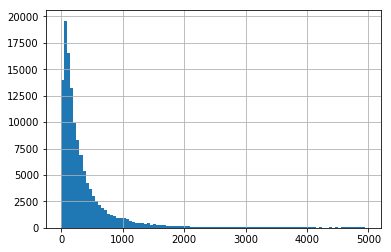

In [20]:
lens = train.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

The majority of our texts have between 200 and 300 words. we can see few texts that have more that 1500 words. we can decided to train all this words and see how this turns out or we can just train remove all samples that have more than 1500 words. I've decided to train all of them any way.

Let's now see if no comment is empty. in which we could delete it

In [21]:
print('Number of missing comments in comment text on Training set:')
train['comment_text'].isnull().sum()

Number of missing comments in comment text on Training set:


0

In [22]:
print('Number of missing comments in comment text on Validation set:')
validation['comment_text'].isnull().sum()

Number of missing comments in comment text on Validation set:


0

Let's split the input data from the ground truth labels.

In [23]:
X_train, y_train = train['comment_text'].values, train.iloc[:,2:].values
X_val, y_val = validation['comment_text'].values, validation.iloc[:,2:].values
X_test, y_test = test['comment_text'].values, test.iloc[:,2:].values

In [24]:
print('X_train shape ', X_train.shape)
print('y_train shape ', y_train.shape)
print('X_val shape ', X_val.shape)
print('y_val shape ', y_val.shape)
print('X_test shape ', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape  (129251,)
y_train shape  (129251, 6)
X_val shape  (14362,)
y_val shape  (14362, 6)
X_test shape  (15958,)
y_test shape (15958, 6)


In [25]:
y_train

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       ..., 
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

As it can be seen, our labels are still not yet formatted. we need to list all tags of a comment is easy to understand way. for example:
**comment1** will have a new tag safe which means safe comment.
and **comment3** will have an array containing 'severe toxic','obscene','identity_hate'

In [26]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [27]:
classes = {0:'toxic',1:'severe_toxic',2:'obscene',3:'threat',4:'insult',5:'identity_hate'}

Create a function called convertClass that convert our labels as described above. for comments which are safe, add a new tag called safe

In [28]:
def convertClass(tags,classes):
    result = []
    for i,tag in enumerate(tags):
        if tag > 0:
            result.append(classes[i])
    if len(result) == 0:
        result.append('safe')
                
    return result

Let's run our function to all labels data

In [29]:
y_train = np.array([convertClass(tag,classes) for tag in y_train])
y_val = np.array([convertClass(tag,classes) for tag in y_val])
y_test = np.array([convertClass(tag,classes) for tag in y_test])

In [30]:
y_train

array([list(['safe']), list(['safe']),
       list(['toxic', 'obscene', 'insult']), ..., list(['safe']),
       list(['toxic', 'severe_toxic', 'obscene', 'insult']), list(['safe'])], dtype=object)

Our data is almost ready for training. but one more thing needs to be done. we need to clean the comments by removing wrong characters such as special characters. we also need to change the case of all characters that make the comment to avoid case insensitivity our models. we also need to remove stop words since those are words that are likely to be common to all comments. let's print a sample of 3 comments to see what the comments are like

In [31]:
X_train[2:5]

array(['Giant Cunt==\n\nShe is not liberal but in fact a giant cunt.  \n\n==',
       "Sci-Fi Dine-In Theater Restaurant \n\nHello, Neelix. I'm not clear on why you are reverting my edits to this page. Please let me know! I'm attempting to adhere to wiki guidelines and am fairly certain that my edits are in lockstep with them. Thanks!\n\nJohn",
       '(only elligable for new accounts)'], dtype=object)

Let's create a function and call it text_prepare which will be passed a text and return a cleaned version of the text.

In [32]:
import re

In [33]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
NEW_LINE = re.compile('\n')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text
    text = NEW_LINE.sub(' ',text) # replace NEW_LINE symbols in our texts by space
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('',text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    return text

Let's test our function by using a small sample before we can apply the function to all texts.

In [34]:
sample_text = [ 'Possibly related  2 nearby IPs that have also spammed; see talk pages for details:',
       '"\nWhen the category was created there was only one person in the category. I don\'t know anything about the American Protestant groups, so if you need to, you can create the category. Please use Category:Southern Baptist Convention when categorizing individuals who are Southern Baptist.â\x80\x94RyÅ«lÃ³ng (ç«\x9cé¾\x99) "',
       'Giant Cunt==\n\nShe is not liberal but in fact a giant cunt.  \n\n==',
       "Sci-Fi Dine-In Theater Restaurant \n\nHello, Neelix. I'm not clear on why you are reverting my edits to this page. Please let me know! I'm attempting to adhere to wiki guidelines and am fairly certain that my edits are in lockstep with them. Thanks!\n\nJohn",
       '(only elligable for new accounts)']

In [35]:
sample_text_clean = [text_prepare(x) for x in sample_text]
sample_text_clean

['possibly related 2 nearby ips also spammed see talk pages details',
 'category created one person category dont know anything american protestant groups need create category please use categorysouthern baptist convention categorizing individuals southern baptistrylng',
 'giant cunt liberal fact giant cunt',
 'scifi dinein theater restaurant hello neelix im clear reverting edits page please let know im attempting adhere wiki guidelines fairly certain edits lockstep thanks john',
 'elligable new accounts']

In [36]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [37]:
X_train[2:5]

['giant cunt liberal fact giant cunt',
 'scifi dinein theater restaurant hello neelix im clear reverting edits page please let know im attempting adhere wiki guidelines fairly certain edits lockstep thanks john',
 'elligable new accounts']

You can definitely do a better job than I did if you spend more time looking at the data and cleaning accordingly. I am satisfied with the little I did, that I do. so I will move to the next step.

## Data transformation
    In this section we will transform our input text into vectors of numbers that represent each word that makes the training corpus

Let's first create two dictionaries one to hold all words and the number of times they have been used across the corpus. and another to hold all tags and the number of times they have been assigned a comment. these two will be used later when we want to check what the model is learning about some of the most important words in the corpus.

In [38]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
for tags in y_train:
    for tag in tags:
        if tag in tags_counts:
            tags_counts[tag] += 1
        else:
            tags_counts[tag] = 1
# Dictionary of all words from train corpus with their counts.
words_counts = {}

for title in X_train:
    for word in title.split():
        if word in words_counts:
            words_counts[word] += 1
        else:
            words_counts[word] = 1

In [39]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:5]
print('Common tags',most_common_tags)
print('-----------------')
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:5]
print('common words',most_common_words)

Common tags [('safe', 116080), ('toxic', 12427), ('obscene', 6861), ('insult', 6392), ('severe_toxic', 1316)]
-----------------
common words [('article', 45147), ('page', 36777), ('wikipedia', 28784), ('talk', 25741), ('please', 24036)]


There are different ways we can represent each word in a numerical way. the most common are bag of words, TFIDF and Word Embeddings. The later has recently attracted attention of many especially when you have a big corpus of millions of words(including n-grams). I will use this technique in another post where I will cover as similar classification exercise using deep learning. for this exercise though, I will use TFIDF which is an improved version of bag of words which uses inversed logarithmic normalisation to penalise those words that are most frequent accross different input text of our corpus.

Let's use sklearn library to generate tfidf vectors. I will also use n-grams of size 1 and two. you can experiment with size if you have enough RAM on your computer. Also keep in mind that increasing the size of n-grams without increasing the size of samples might generate a lot of features than the size of the sample. this can result into your model being high biased.

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

Create a function that convert each set of our traing, validation and test corpus into a TFIDF matrix

In [41]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1, 2),token_pattern='(\S+)')
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Run the functiion agains the training set, validation and the test. check if most common words of our corpus are still there. this is crucial since the performance our model will depend on the TFIDF representation of the data sets.
Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. You can filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary.

In [42]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [43]:
print('article' in tfidf_vocab)
print('page' in tfidf_vocab)
print('wikipedia' in tfidf_vocab)
print('please' in tfidf_vocab)
print('talk' in tfidf_vocab)

True
True
True
True
True


Check the size of our training set to find out how many features are we going to train.

In [44]:
print('X_train_tfidf shape ', X_train_tfidf.shape)
print('X_val_tfidf shape ', X_val_tfidf.shape)
print('X_test_tfidf shape ', X_test_tfidf.shape)

X_train_tfidf shape  (129251, 121181)
X_val_tfidf shape  (14362, 121181)
X_test_tfidf shape  (15958, 121181)


## Training the classifier

Now that our different data are ready. let's decide on the training technic. since this exercise requires to predict tags for each comment and since a comment can have zero, one or more than one tags, we will need to use a model that consider each input of tfidf vectors representing words of each comment; and each tag individually and evaluate the probability that the input can be assigned the tag(output 1) or otherwise (output 0). we will use the MultiLabelBinarizer of sklearn to convert each tag into a binary form.

In [45]:
from sklearn.preprocessing import MultiLabelBinarizer

In [46]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)
#y_test = mlb.fit_transform(y_test)

Now that the tags have been converted into binary representation, let's build our classifier. we will use OneVsRestClassifier to train each binary tag individually and we will use basic classify called LogisticRegression as the upper layer. It is one of the simplest methods, but often it performs good enough in text classification tasks.

In [47]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [48]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    
    lr = LogisticRegression(C=4.0,penalty='l2') # use L2 to optimise
    ovr = OneVsRestClassifier(lr)
    ovr.fit(X_train, y_train)
    return ovr

Let's run the classifier function against our training set

In [49]:
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

Let's use the model to predict first the output of using our training set. also get the score to be used for evaluation

In [50]:
y_train_predicted_labels_tfidf = classifier_tfidf.predict(X_train_tfidf)
y_train_predicted_scores_tfidf = classifier_tfidf.decision_function(X_train_tfidf)

Let's print a sample of 200 comments of our training set and compare what the model predicted vs the true labels

In [51]:
y_train_pred_inversed = mlb.inverse_transform(y_train_predicted_labels_tfidf)
y_train_inversed = mlb.inverse_transform(y_train)
for i in range(200):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_train[i],
        ','.join(y_train_inversed[i]),
        ','.join(y_train_pred_inversed[i])
    ))

Title:	possibly related 2 nearby ips also spammed see talk pages details
True labels:	safe
Predicted labels:	safe


Title:	category created one person category dont know anything american protestant groups need create category please use categorysouthern baptist convention categorizing individuals southern baptistrylng
True labels:	safe
Predicted labels:	safe


Title:	giant cunt liberal fact giant cunt
True labels:	insult,obscene,toxic
Predicted labels:	insult,obscene,toxic


Title:	scifi dinein theater restaurant hello neelix im clear reverting edits page please let know im attempting adhere wiki guidelines fairly certain edits lockstep thanks john
True labels:	safe
Predicted labels:	safe


Title:	elligable new accounts
True labels:	safe
Predicted labels:	safe


Title:	consider reported
True labels:	safe
Predicted labels:	safe


Title:	sure enough lets stubify grow
True labels:	safe
Predicted labels:	safe


Title:	democracy little book c major 1916 p 19 mencken writes democracy theory

Our model seems to be doing well on the training set. but that was expected. let's now predict the validation set

In [52]:
y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [53]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(200):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	innovation integration tactics development training testing
True labels:	safe
Predicted labels:	safe


Title:	josef stalin edits absolutely retarded ben something funny
True labels:	safe
Predicted labels:	safe


Title:	watching think said 6 months ago 300 article asked stalking edits said bad faith gave right exercising right considering bad faith demonstrated behave likely grow bored remove observation cast spell
True labels:	safe
Predicted labels:	safe


Title:	also agree could greater focus laws section also think statistics showed percentage women affected violence affects dowry system put numbers would help make article concrete expanding dowry system exactly related violence helpful well cited needs expansion added parts important written well
True labels:	safe
Predicted labels:	safe


Title:	like insteaf od partakin gin discussion since last posted waqll havent edited part question since user insisted refuting discussion based consensus goes ani supposed discussion follow

Title:	posted wiki internet gwen gale yet afraid someone else googling name old boy mafia
True labels:	safe
Predicted labels:	safe


Title:	photo anyone photo could used article 98232181201
True labels:	safe
Predicted labels:	safe


Title:	norman architecture bob well thats another educational resource page link youve removed
True labels:	safe
Predicted labels:	safe


Title:	edit war hi sam56mas letting know weve gone backwards forwards couple times lately supportads reference link looks like youve part removed broken link earlier edit ive restored reason im inclined leave place relevant link link regarding topic provided sydney star observer ive noticed people issue ill reinsert days dont object maybe im missing something assumptions dont want reason im happy leave would prefer gone reason problem ill leave given histoy page im avoiding anything makes look like edit warring
True labels:	safe
Predicted labels:	safe


Title:	yes extensive foreign experience explains talked alaska narrow

Not bad either. However our training data set is big and has a hundred of thousands of comments. the validation set is also big. we can 't evaluate each example by comparing labels. we need some numbers that can help us to understand how the model performed. we will use a combination of accuracy, f1 score, precision, recall and roc curve. you can read more about the evaluation methods by following the links.
- [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
- [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
- [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 

In [54]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Let's create a function that prints the metrics that specified above

In [55]:
def print_evaluation_scores(y_val, predicted):
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    print('Accuracy:',accuracy_score(y_val, predicted))
    print('F1 Score:',f1_score(y_val, predicted, average='weighted'))
    print('Precision:',average_precision_score(y_val, predicted,average='weighted'))
    print('Recall:',recall_score(y_val, predicted,average='weighted'))

In [56]:
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Accuracy: 0.918256510235
F1 Score: 0.922387498956
Precision: 0.879203307783
Recall: 0.916125405946


We can see that the accuracy is quite impressive. but that was not a surprise and it does not mean the model is performing well. You remember when I discussed about sparse data? this is what I was referring too. since one class is 90% dominant, predicting everytime that class will give us a 90% accuracy. almost what we see here. does that mean we are not doing well since we are getting only 91% accuracy? not yet. let's think about the precission and recall. for a quick reminder see this [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall).
It is clear that the precision and recall are not telling all as well. same as F1 score. so we still need to analyse the area under the curve.

In [57]:
from metrics import roc_auc
%matplotlib inline

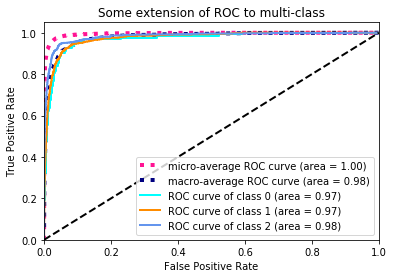

In [58]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

Our ROC curve looks good. there is a good trade-off between sensitivity and specificity. that can be told by looking how closely the curve is approaching both the left side and the top side. our model is not bias nor it has a high variance. well done.

Now let's apply the model on the test set. this will allow us to see whether our model is generalising

In [59]:
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)
y_test_predicted_scores_tfidf = classifier_tfidf.decision_function(X_test_tfidf)

In [60]:
y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = y_test#mlb.inverse_transform(y_test)
for i in range(200):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))

Title:	innovation integration tactics development training testing
True labels:	safe
Predicted labels:	safe


Title:	josef stalin edits absolutely retarded ben something funny
True labels:	safe
Predicted labels:	safe


Title:	watching think said 6 months ago 300 article asked stalking edits said bad faith gave right exercising right considering bad faith demonstrated behave likely grow bored remove observation cast spell
True labels:	safe
Predicted labels:	safe


Title:	also agree could greater focus laws section also think statistics showed percentage women affected violence affects dowry system put numbers would help make article concrete expanding dowry system exactly related violence helpful well cited needs expansion added parts important written well
True labels:	safe
Predicted labels:	safe


Title:	like insteaf od partakin gin discussion since last posted waqll havent edited part question since user insisted refuting discussion based consensus goes ani supposed discussion follow

A quick look at the examples, shows that the model is doing well on the test set.

In [61]:
y_test_binary = mlb.fit_transform(y_test)
print_evaluation_scores(y_test_binary, y_test_predicted_labels_tfidf)

Accuracy: 0.921042737185
F1 Score: 0.923328020394
Precision: 0.881731181677
Recall: 0.914824374369


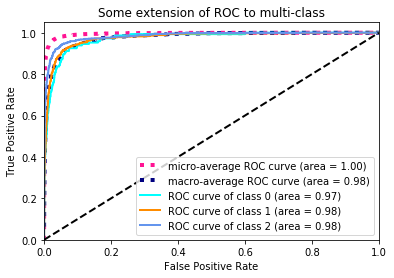

In [62]:
n_classes = len(tags_counts)
roc_auc(y_test_binary, y_test_predicted_scores_tfidf, n_classes)

The ROC curve also suggest that things are good.

### Some things you can do

Pheeeew, we have now built our model and we are happy with the level of performance it shows on the comment data set. let's now do something interesting. I found this a bit interesting and even funny. it is my favorite part for NLP models. let's see what our models did actually learn. let's ask our model to tell us the most positive words and the most negative words associated with each tag. sounds fun. Yuuuhuu.

In [63]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    est = classifier.estimators_[tags_classes.index(tag)]
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    
    top_positive_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][-5:]]# top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][:5]]# bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [64]:
DICT_SIZE = len(words_counts)
WORDS_TO_INDEX = {word[0]:i for i,word in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}
INDEX_TO_WORDS = {WORDS_TO_INDEX[i]:i for i in WORDS_TO_INDEX}####### YOUR CODE HERE #######
####### YOUR CODE HERE #######
ALL_WORDS = WORDS_TO_INDEX.keys()

In [65]:
print_words_for_tag(classifier_tfidf, 'safe', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'identity_hate', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'insult', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'obscene', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'severe_toxic', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'threat', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'toxic', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	safe
Top positive words:	agree, best, thank, redirect, thanks
Top negative words:	fuck, fucking, shit, idiot, stupid

Tag:	identity_hate
Top positive words:	jew, nigga, gay, homosexual, nigger
Top negative words:	article, talk, better, source, see

Tag:	insult
Top positive words:	idiots, bitch, stupid, asshole, idiot
Top negative words:	redirect, thanks, talk, could, article

Tag:	obscene
Top positive words:	bitch, shit, asshole, fucking, fuck
Top negative words:	thanks, manners, article, section, cheers

Tag:	severe_toxic
Top positive words:	fuckin, motherfucker, fcking, fucking, fuck
Top negative words:	article, please, talk, ass fuck, redirect

Tag:	threat
Top positive words:	destroy, rape, death, die, kill
Top negative words:	article, please, thanks, dont u, isnt

Tag:	toxic
Top positive words:	stupid, idiot, shit, fucking, fuck
Top negative words:	thanks, thank, redirect, best, may



**Impressive , Hein!!!** our model can learn words that are most positive for each category. a few take on though. first some classes are ambigious and negative words are sometimes words that have nothing to do with the tag. for instance if a comment has a word article then the model might this is not offensive even when it is. depending on other words that make the comment,then the model might classify as a toxic comment. it is good to see what the model learn since that way you can improve your model by providing more examples.

## Save the model to the disk for later use

In [66]:
import pickle

In [67]:
# save the model to disk
filename = 'classify_wiki_comments.sav'
pickle.dump(classifier_tfidf, open(filename, 'wb'))

In [68]:
# in case you would like to reload the model from the disk. just do
loaded_model = pickle.load(open(filename, 'rb'))